In [247]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
# Joachim DAVID, December 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
# @book{ebeling2004introduction,
#   title={An introduction to reliability and maintainability engineering},
#   author={Ebeling, C.E.},
#   isbn={9780070421387},
#   series={Electrical engineering series},
#   url={https://books.google.be/books?id=iFumyeVLIEAC},
#   year={2004},
#   publisher={McGraw-Hill}
# }

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot
from datetime import datetime, timedelta

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
file_used = 'productionfile.csv'

round_to = 600 # seconds
break_pauses = 7200 # seconds # breaks will be split in these periods
turn_off_if = 3600 # seconds # the machine can be turned off if time if larger than this!!!! has to be smaller than the breaks indicated here
assert (turn_off_if < break_pauses)

In [249]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [250]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
reasons_relative = [1, 3, 5, 7, 8]
reasons_absolute = [9, 10, 11]
reasons_break = [2]
considered_reasons = reasons_relative + reasons_absolute + reasons_break
# group = True
choice='PastaType'

# PLOT_RANGE:
plotrange = datetime(2016, 11, 3, 6, 0), datetime(2016, 12, 3, 0, 0)

In [251]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES', 'HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

In [252]:
df.head()

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,PastaType
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.0,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.0,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.0,8,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
3,50,50675.0,74525.0,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871.0,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
4,50,50675.0,74525.0,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177.0,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI


### Export for simulator file and visualise

In [253]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE'})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [254]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK
1,50675,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860,100,MACARONI KORT PLATTE ZAK
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK
3,50675,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871,100,MACARONI KORT PLATTE ZAK
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK


In [255]:
df_task.ProductionRequestId.unique()

array([50675.0, -1, -2, ..., 77326.0, -2284, 77248.0], dtype=object)

In [256]:
df_prod  = df_task[df_task.ArticleName != 'NONE']
prodtime = df_prod.Duration.sum() / 3600
uptime = df_prod.Duration[df_prod.ReasonId.isin([100])].sum() / 3600
downtime = df_prod.Duration[df_prod.ReasonId.isin(all_reasons)].sum() / 3600

reltime = df_prod.Duration[df_prod.ReasonId.isin(reasons_relative)].sum() / 3600
abstime = df_prod.Duration[df_prod.ReasonId.isin(reasons_absolute)].sum() / 3600
breaktime = df_prod.Duration[df_prod.ReasonId.isin(reasons_break)].sum() / 3600

idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('> Runtime {:.3f} h'.format(uptime))
print('> Downtime {:.3f} h'.format(downtime))

print('>> Unexpected breakdowns {:.3f} h'.format(reltime))
print('>> Expected breaks {:.3f} h'.format(abstime))
print('>> Pause {:.3f} h'.format(breaktime))

print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13218.464 h
> Runtime 10309.660 h
> Downtime 2908.804 h
>> Unexpected breakdowns 1413.382 h
>> Expected breaks 1494.684 h
>> Pause 0.738 h
Idle time 3121.736 h
Total time 16340.199 h


In [257]:
#df_task

4280


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


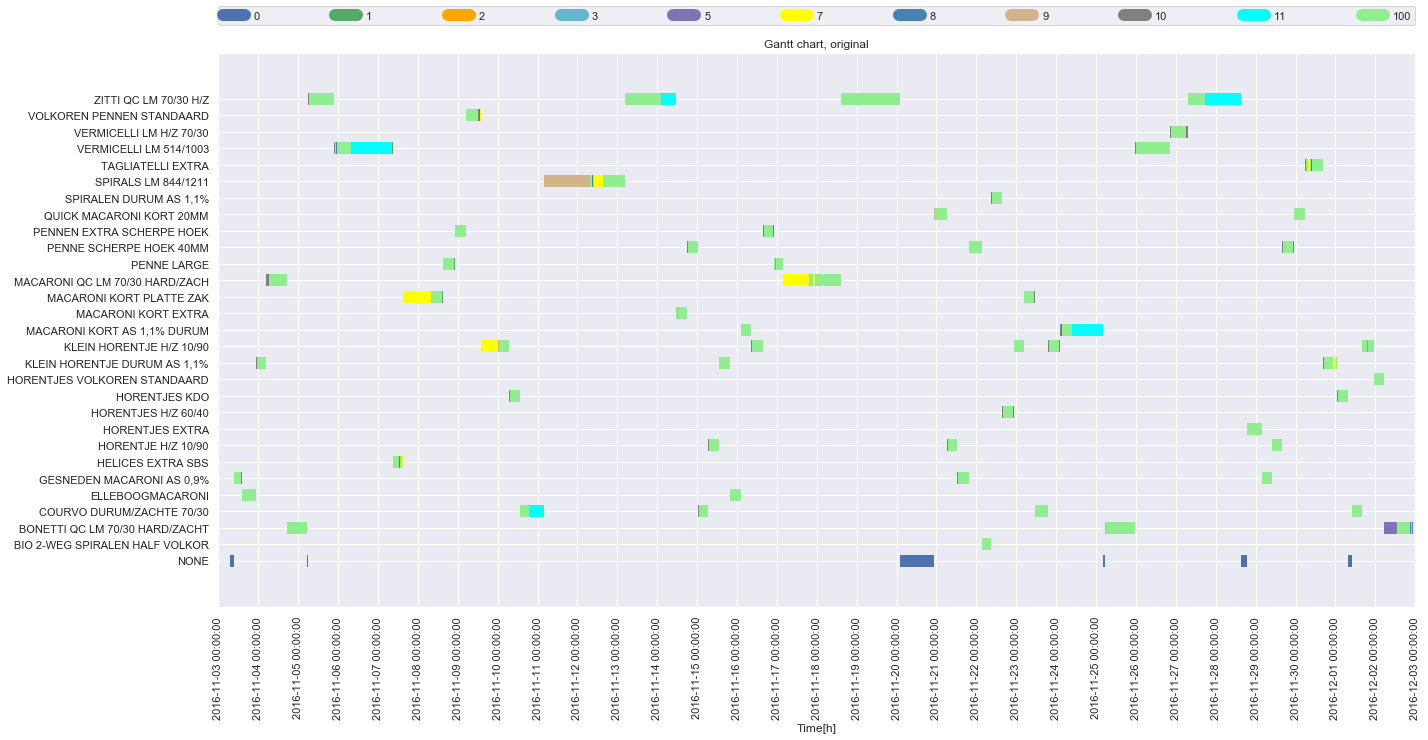

In [258]:
def show_gantt(start, end):
    plt.figure(figsize=(20, 10))
    # df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    # df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
    df_part = df_task[df_task.StartDateUTC.between(start, end) & df_task.EndDateUTC.between(start, end)]
    all_reasons = list(df_task.ReasonId.unique())
    all_reasons.sort()
    plot_gantt(df_part, 'ReasonId', 'ArticleName', order=all_reasons)
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # key_list = sorted(by_label)
    # value_list = [by_label[key] for key in key_list]
    # plt.legend(value_list, key_list, loc='lower right')
    plt.title('Gantt chart, original')
    #try:
    #    plt.savefig('D:/temp/gantt.svg', dpi=1200, bbox_inches='tight')
    #except:
    #    pass
    plt.tight_layout()
    plt.show()
show_gantt(*plotrange)

In [259]:
def sliding_plot(start, ran):
    from datetime import datetime, timedelta

    plotrange = datetime(2016, 11, 2, 0, 0) + timedelta(start), datetime(2016, 11, 2, 0, 0) + timedelta(start+ran)

    show_gantt(*plotrange)

In [260]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

a = widgets.FloatText()
b = widgets.FloatSlider(min=0, max=100, step=1)
display(a)
c = widgets.FloatSlider(min=1, max=14, step=1)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

interact(sliding_plot, start=b, ran=7)

FloatText(value=0.0)

interactive(children=(FloatSlider(value=0.0, description='start', step=1.0), IntSlider(value=7, description='ran', max=21, min=-7), Output()), _dom_classes=('widget-interact',))

<function __main__.sliding_plot>

In [261]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [262]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    #print(len(group))
    group_uptime = df_task[df_task.ReasonId.isin([0, 100])].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_uptime.columns = ['Uptime']
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime.columns = ['Totaltime']
    group_downtime = df_task[df_task.ReasonId.isin(considered_reasons)].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_downtime.columns = ['Downtime']
    group = pd.concat([group_uptime, group_downtime, group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.index = group.index.astype(int)
    group = group.fillna(0)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    #df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
#    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
#         if i == 0:
#             df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
#             df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
#             i += 1
#         df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
#         df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
#        df.loc[j, ]

    df['StartDateUTC'] = df['StartDateUTC'].dt.round(str(num_minutes) + 's')
    df['EndDateUTC'] = df['EndDateUTC'].dt.round(str(num_minutes) + 's')
    df['Duration'] = (df['EndDateUTC'] - df['StartDateUTC']).dt.total_seconds()
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Totaltime'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0): #& (df.loc[previdx, 'ArticleName'] != 'NONE'):
                # extend the previous job
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Totaltime'] += df.loc[curidx, 'Totaltime']
                df.loc[previdx, 'Uptime'] += df.loc[curidx, 'Uptime']
                df.loc[previdx, 'Downtime'] += df.loc[curidx, 'Downtime']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output):
    out = group[['Uptime', 'Totaltime', 'StartDateUTC', 'EndDateUTC', 'ArticleName']].copy()
    out.columns = ['Uptime', 'Totaltime', 'Start', 'End', 'Product']
    out[['Uptime', 'Totaltime']] = out[['Uptime', 'Totaltime']] / 3600
    for col in ['Start', 'End']:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.insert(3, 'Quantity', 20)
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    out.index.name = 'ID'
    out.to_csv(output)
    
def construct_downtimes(group, reasons):
    dt = group.copy()
    dt = dt[dt['ReasonId'].isin(reasons)]
    return dt

def save_downtimes(dt, output):
    out = dt.copy()
    out = out[['StartDateUTC', 'EndDateUTC']]
    out = out.reset_index(drop=True)
    out.index.name = 'ID'
    out.to_csv(output)

#print(len(df_task))
group = group_productions(df_task)
#print(len(group))
print(group.columns)
group = remove_breaks(group, 3600)
len(group)
#group = simplify_productions(group, 600)
#print(len(group))
downtime = construct_downtimes(df_task, considered_reasons)
save_downtimes(downtime, os.path.join(filepath,'historicalDownPeriods.csv'))

Index(['Uptime', 'Downtime', 'Totaltime', 'StartDateUTC', 'EndDateUTC',
       'ArticleName'],
      dtype='object')


In [263]:
len(group)

2672

In [264]:
prodtime = group.Totaltime[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Totaltime[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13296.306 h
Idle time 3043.893 h
Total time 16340.199 h


In [265]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'))
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [266]:
def energy_per_production(group):
    articlenum = len(group.ArticleName.unique())
    rand = np.random.random_sample((articlenum,)) * 0.2 + 0.1
    energycons = pd.concat([pd.Series(group.ArticleName.unique()), pd.Series(rand)], axis=1)
    energycons.columns = ['Product', 'Power']
    energycons.insert(1, 'UnitPrice', 5)
    energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    return energycons

energycons = energy_per_production(group)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [267]:
energycons.head()

,Product,UnitPrice,Power,TargetProductionRate
0,MACARONI KORT PLATTE ZAK,5,0.124471,3000
1,NONE,5,0.000000,3000
2,"GESNEDEN MACARONI AS 0,9%",5,0.146311,3000
3,PENNE SCHERPE HOEK 40MM,5,0.219559,3000
4,KLEIN HORENTJE H/Z 10/90,5,0.103749,3000


In [268]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [269]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [270]:
group.head()

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,,,
50675,18996.0,655.0,19651.0,2016-01-19 14:21:47.980,2016-01-19 19:49:18.047,MACARONI KORT PLATTE ZAK
-1,7200.0,0.0,7200.0,2016-01-19 19:49:18.047,2016-01-19 21:49:18.047,NONE
-2,7200.0,0.0,7200.0,2016-01-19 21:49:18.047,2016-01-19 23:49:18.047,NONE
-3,7200.0,0.0,7200.0,2016-01-19 23:49:18.047,2016-01-20 01:49:18.047,NONE
-4,7200.0,0.0,7200.0,2016-01-20 01:49:18.047,2016-01-20 03:49:18.047,NONE


In [271]:
downtime.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK
26,50724,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126,9,"GESNEDEN MACARONI AS 0,9%"
28,50724,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294,8,"GESNEDEN MACARONI AS 0,9%"


In [272]:
plotrange

(datetime.datetime(2016, 11, 3, 6, 0), datetime.datetime(2016, 12, 3, 0, 0))

In [273]:
group_part.tail(10)

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName,PastaType,Start,End
ProductionRequestId,,,,,,,,,
63151,23442.010,1084.0,24526.010,2016-11-29 15:56:36.937,2016-11-29 22:45:22.997,PENNE SCHERPE HOEK 40MM,PENNE,639.943594,646.756388
63089,25082.000,700.0,25782.000,2016-11-29 22:45:22.997,2016-11-30 05:55:04.023,QUICK MACARONI KORT 20MM,MACARONI,646.756388,653.917784
63133,30625.000,8043.0,38668.000,2016-11-30 05:55:04.023,2016-11-30 16:39:32.187,TAGLIATELLI EXTRA,Other,653.917784,664.658941
63169,22825.000,7326.0,30151.000,2016-11-30 16:39:32.187,2016-12-01 01:02:03.880,"KLEIN HORENTJE DURUM AS 1,1%",SPIRELLI,664.658941,673.034411
62899,21687.000,1755.0,23442.000,2016-12-01 01:02:03.880,2016-12-01 07:32:45.777,HORENTJES KDO,SPIRELLI,673.034411,679.546049
-1540,9311.396,0.0,9311.396,2016-12-01 07:32:45.777,2016-12-01 10:07:57.173,NONE,NONE,679.546049,682.132548
63181,21086.010,270.0,21356.010,2016-12-01 10:07:57.173,2016-12-01 16:03:53.010,COURVO DURUM/ZACHTE 70/30,Other,682.132548,688.064725
63070,23509.997,1199.0,24708.997,2016-12-01 16:03:53.010,2016-12-01 22:55:42.047,KLEIN HORENTJE H/Z 10/90,SPIRELLI,688.064725,694.928346
62622,20577.993,1237.0,21814.993,2016-12-01 22:55:42.047,2016-12-02 04:59:17.973,HORENTJES VOLKOREN STANDAARD,SPIRELLI,694.928346,700.988326


C:\Users\jdavid\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

-1491


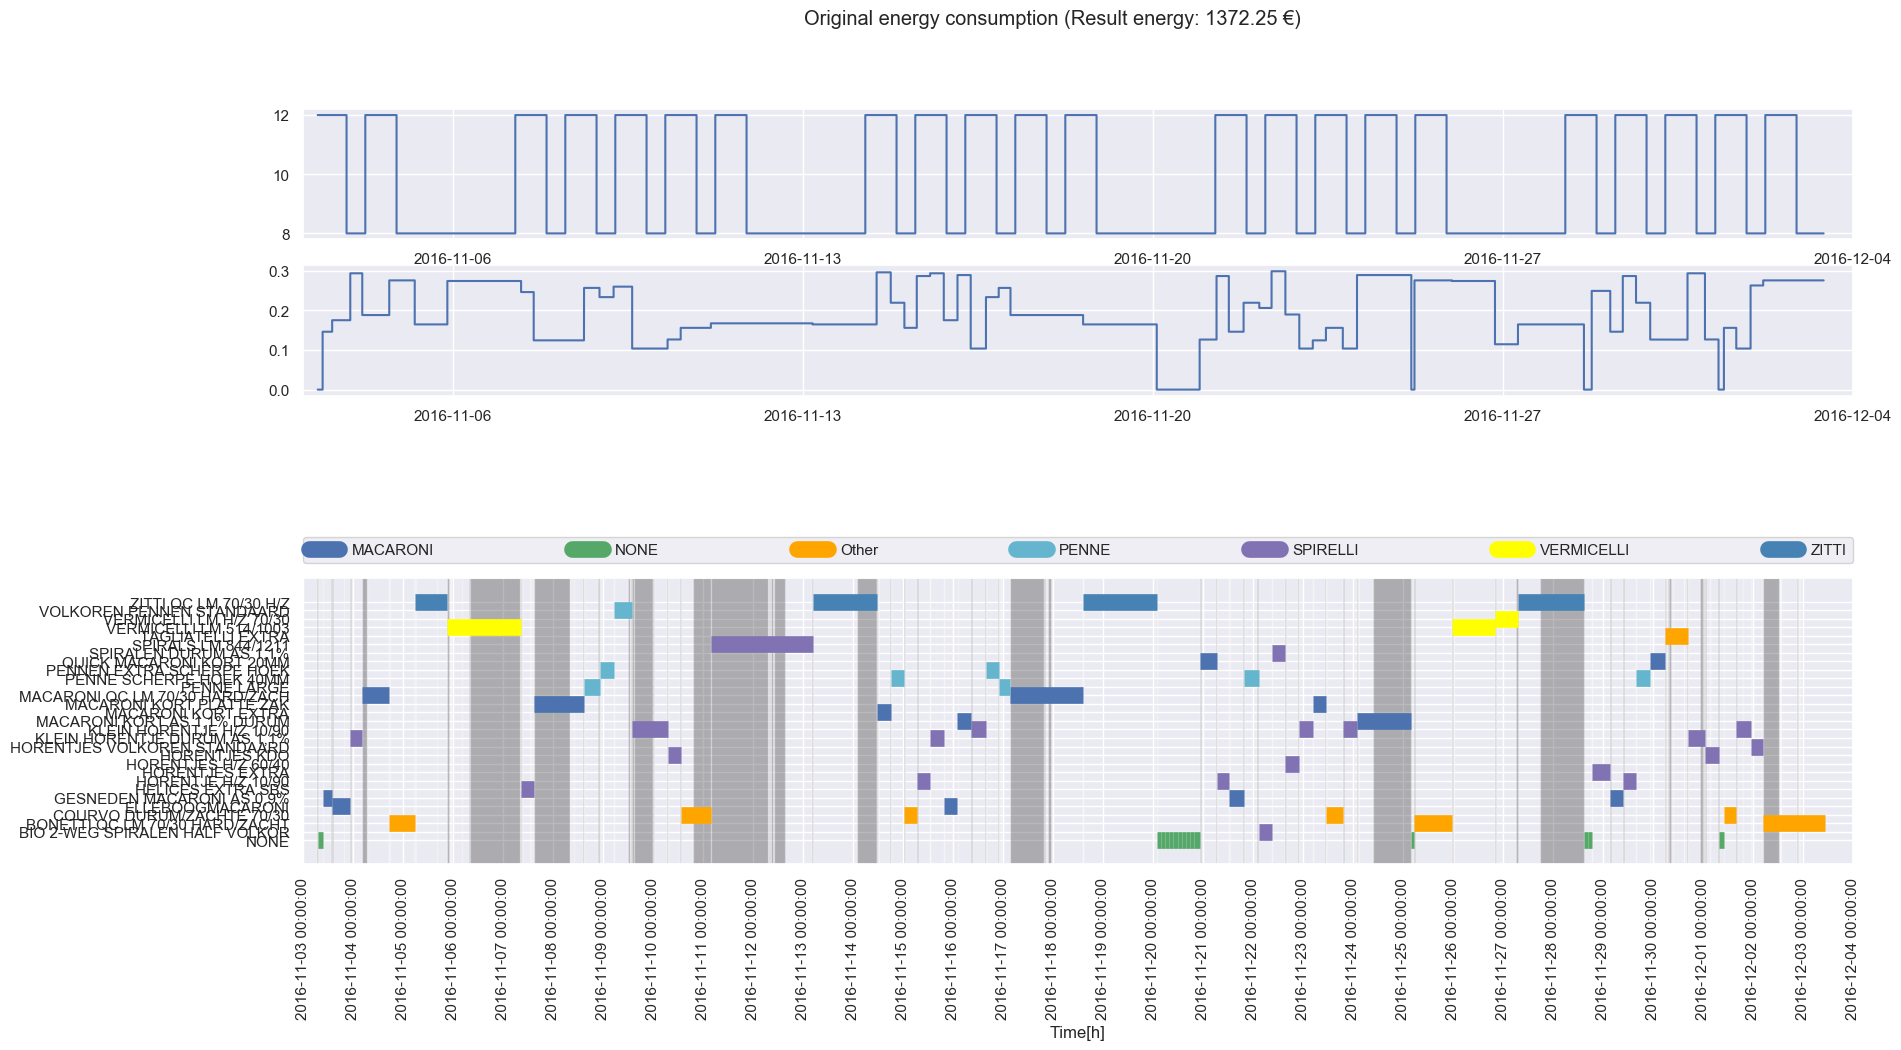

In [274]:
group_part = group[group.StartDateUTC.between(*plotrange)]
downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

plt.figure(figsize=(20, 10), dpi=100)
c, table = calculate_energy_cost(group_part, prices, energycons, True)

plt.subplot(5,1,(4,5))
timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
plt.subplot(5,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(5,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
try:
    plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
except:
    print('No output made.')
    pass
plt.show()

In [275]:
start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
start_time, end_time

(Timestamp('2016-01-19 14:21:47.980000'),
 Timestamp('2017-11-30 10:33:39.177000'))

In [276]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, worst_curve, gen = run_opt(*plotrange, 
       [], [],
        *files, 
        1, 2000, 0.4, 0.4, 12, num_mutations=1, adaptive=[],
        stop_condition='num_iterations', stop_value=None, 
        weight_energy = 1, weight_failure=0, weight_conversion = 1, weight_before = 0)

Unexpected error when reading down duration information from '[]'


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:1209: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  #                                     product_related_characteristics_dict, down_duration_dict, scenario)


2000/2000:	937.9024488455715
Elapsed time: 56.94 s

Candidate schedule [-1531 -1518 63133 62216 -1536 62529 62630 62729 62384 62215 62465 -1517
 -1515 -1540 61892 -1513 62904 62259 62217 62753 -1520 -1522 62899 62258
 63181 62769 62898 62985 62984 62854 62497 -1491 62495 62983 -1516 63062
 63089 -1521 62260 63056 62945 62082 62231 62023 62253 63169 62622 62022
 -1514 -1535 62623 63151 62402 62805 62850 62496 63110 62179 62789 61962
 62214 62523 62024 63070 62528 62788 62763 62848 62218 -1519 62628]
Candidate failure cost: 0
Candidate energy cost: 887.9024488455715
Candidate conversion cost: 50
Candidate deadline cost 0
Candidate total cost: 937.9024488455715

Original schedule: [-1491, 61962, 62082, 62179, 62022, 62024, 61892, 62023, 62253, 62217, 62216, 62215, 62218, 62214, 62259, 62260, 62231, 62384, 62402, 62465, 62497, 62495, 62496, 62523, 62258, 62528, 62529, 62623, 62630, 62753, -1513, -1514, -1515, -1516, -1517, -1518, -1519, -1520, -1521, -1522, 62769, 62628, 62763, 62788, 6278

In [277]:
best_sched = list(best_sched.keys())

In [278]:
def reorder_schedule(id_list, schedule):
    df = schedule.loc[id_list]
    startdate = df['StartDateUTC'].min()
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Totaltime'], unit='s')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [279]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,,,
-1531,5448.227,0.0,5448.227,2016-11-03 07:08:12.890,2016-11-03 08:39:01.117,NONE,0
-1518,7200.000,0.0,7200.000,2016-11-03 08:39:01.117,2016-11-03 10:39:01.117,NONE,0
63133,30625.000,8043.0,38668.000,2016-11-03 10:39:01.117,2016-11-03 21:23:29.117,TAGLIATELLI EXTRA,100
62216,23656.987,3191.0,26847.987,2016-11-03 21:23:29.117,2016-11-04 04:50:57.104,PENNE LARGE,100
-1536,6236.610,0.0,6236.610,2016-11-04 04:50:57.104,2016-11-04 06:34:53.714,NONE,0


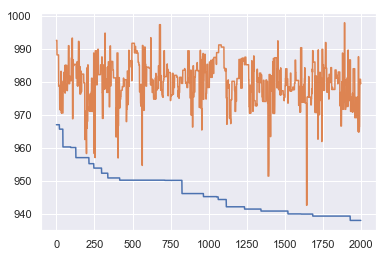

In [280]:
plt.plot(best_curve)
plt.plot(worst_curve)

In [281]:
group_opt.head(10)

,Uptime,Downtime,Totaltime,StartDateUTC,EndDateUTC,ArticleName,ReasonId
ProductionRequestId,,,,,,,
-1531,5448.227,0.0,5448.227,2016-11-03 07:08:12.890,2016-11-03 08:39:01.117,NONE,0
-1518,7200.000,0.0,7200.000,2016-11-03 08:39:01.117,2016-11-03 10:39:01.117,NONE,0
63133,30625.000,8043.0,38668.000,2016-11-03 10:39:01.117,2016-11-03 21:23:29.117,TAGLIATELLI EXTRA,100
62216,23656.987,3191.0,26847.987,2016-11-03 21:23:29.117,2016-11-04 04:50:57.104,PENNE LARGE,100
-1536,6236.610,0.0,6236.610,2016-11-04 04:50:57.104,2016-11-04 06:34:53.714,NONE,0
62529,20576.587,1472.0,22048.587,2016-11-04 06:34:53.714,2016-11-04 12:42:22.301,PENNEN EXTRA SCHERPE HOEK,100
62630,61262.910,64229.0,125491.910,2016-11-04 12:42:22.301,2016-11-05 23:33:54.211,MACARONI QC LM 70/30 HARD/ZACH,100
62729,72858.987,1391.0,74249.987,2016-11-05 23:33:54.211,2016-11-06 20:11:24.198,VERMICELLI LM 514/1003,100
62384,76418.003,34231.0,110649.003,2016-11-06 20:11:24.198,2016-11-08 02:55:33.201,ZITTI QC LM 70/30 H/Z,100


-1531


C:\Users\jdavid\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


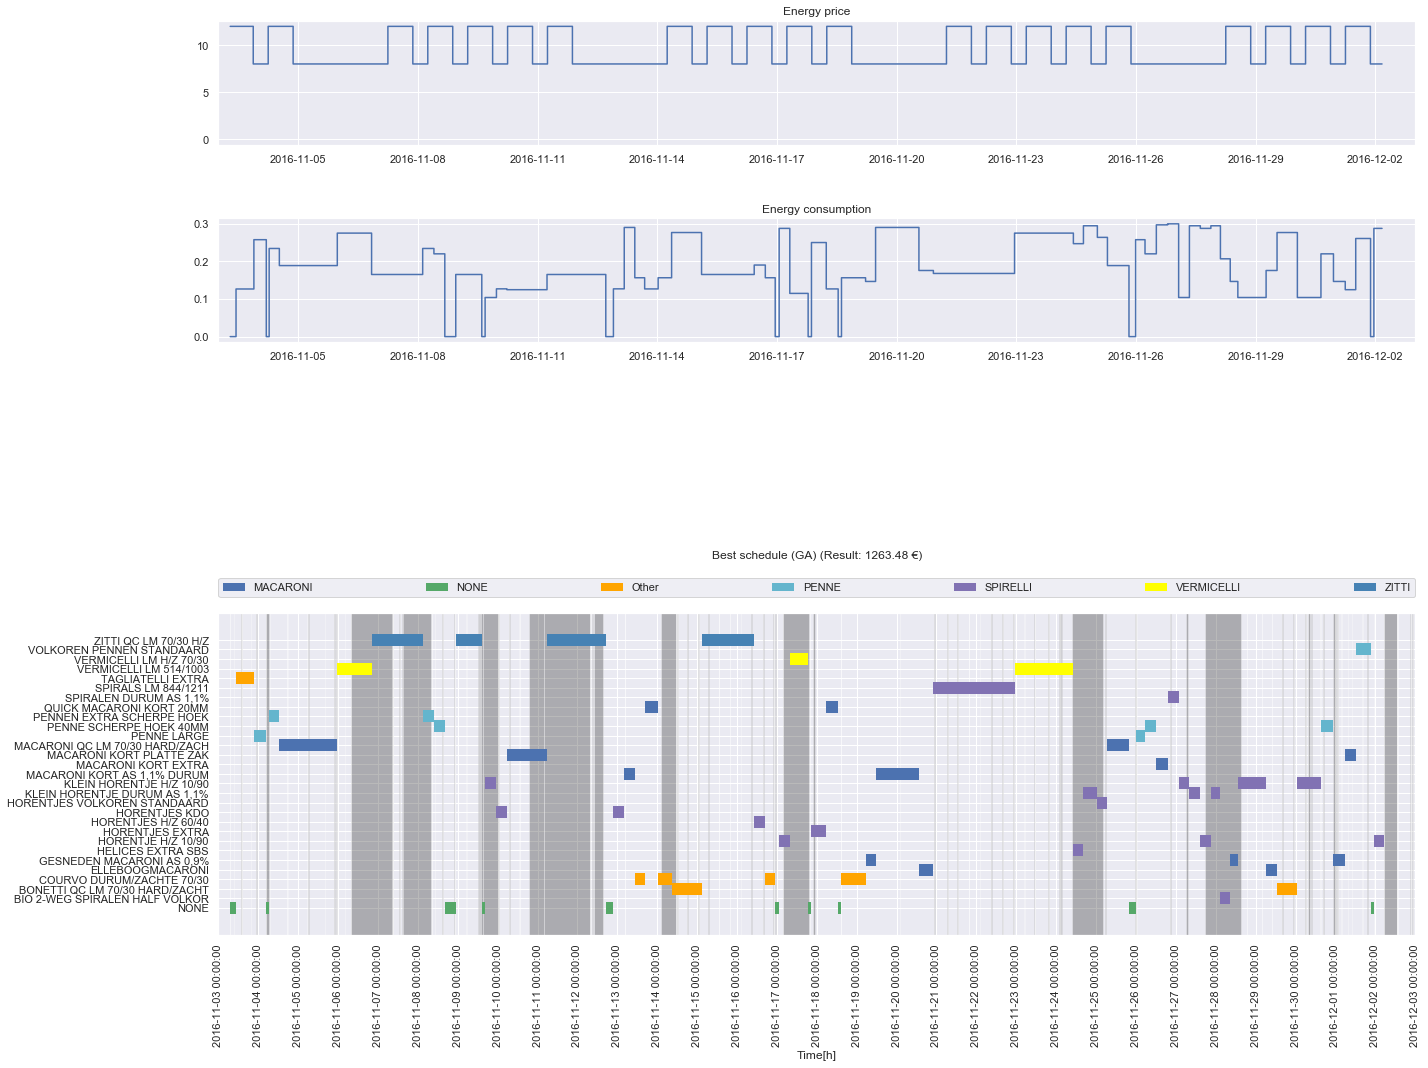

In [296]:
plt.figure(figsize=(20, 15))
show_energy_plot(add_column_type(group_opt, choice=choice), prices, energycons, 'Best schedule (GA)', 'PastaType', downtimes=downtime_temp)
plt.show()

In [283]:
# group_part = group_opt[group_opt.StartDateUTC.between(*plotrange)]
# downtime_temp = downtime[downtime.StartDateUTC.between(*plotrange)]

# plt.figure(figsize=(20, 10))
# c, table = calculate_energy_cost(group_part, prices, energycons, True)

# plt.subplot(5,1,(4,5))
# timerange = plot_gantt(add_column_type(group_part, choice='PastaType'), 'PastaType', 'ArticleName', downtimes=downtime_temp)
# plt.subplot(5,1,1)
# plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Euro, drawstyle='steps-post')

# plt.subplot(5,1,2)
# plt.xlim(timerange[0], timerange[-1])
# plt.plot(table.Power, drawstyle='steps-post')
# try:
#     plt.savefig('D:/temp/gantt_detailed.svg', dpi=1200, bbox_inches='tight')
# except:
#     print('No output made.')
#     pass
# plt.show()

In [284]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [285]:
# df_task.Resource.unique()

In [286]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [287]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours